# Prof of concept Ibis.MapD Geo Spatial Data Types

In [1]:
import pymapd

/mnt/sda1/storage/miniconda/envs/ibis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
conn_info = dict(
    host='localhost', port='9091', 
    user='mapd', password='HyperInteractive', 
    dbname='mapd'
)

conn = pymapd.connect(**conn_info)

In [3]:
conn.get_tables()

['omnisci_states', 'omnisci_counties', 'omnisci_countries']

In [4]:
t_name = 'omnisci_states'

In [5]:
conn.get_table_details(t_name)

[ColumnDetails(name='id', type='STR', nullable=True, precision=0, scale=0, comp_param=32),
 ColumnDetails(name='abbr', type='STR', nullable=True, precision=0, scale=0, comp_param=32),
 ColumnDetails(name='name', type='STR', nullable=True, precision=0, scale=0, comp_param=32),
 ColumnDetails(name='omnisci_geo', type='MULTIPOLYGON', nullable=True, precision=23, scale=4326, comp_param=32)]

In [6]:
import ibis

In [7]:
ibis_conn_info = conn_info.copy()
ibis_conn_info['database'] = ibis_conn_info['dbname']
del ibis_conn_info['dbname']

ibis_conn = ibis.mapd.connect(**ibis_conn_info)

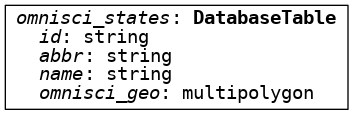

In [8]:
t = ibis_conn.table(t_name)
t

In [9]:
print(t[t.omnisci_geo.area().name('area')].head().execute())

         area
0   12.874780
1  281.894593
2   28.951159
3   13.573046
4   41.644424


In [10]:
print(t[t.omnisci_geo.perimeter().name('perimeter')].head().execute())

    perimeter
0   16.546430
1  266.490637
2   22.749151
3   16.556801
4   34.613895


In [11]:
linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring")
expr = t[[t, linestring1.length().name('length')]]
print(expr.head().compile())
expr.head().execute()

SELECT *, ST_LENGTH('LINESTRING(0 1, 2 3)') AS length
FROM omnisci_states
LIMIT 5


,id,abbr,name,omnisci_geo,rowid,length
0,01,AL,Alabama,MULTIPOLYGON (((-87.3592959471789 35.001179988...,0,2.828427
1,02,AK,Alaska,MULTIPOLYGON (((-131.602020939627 55.117981967...,1,2.828427
2,04,AZ,Arizona,MULTIPOLYGON (((-109.042502962538 37.000262973...,2,2.828427
3,05,AR,Arkansas,MULTIPOLYGON (((-94.4738419514493 36.501860970...,3,2.828427
4,06,CA,California,MULTIPOLYGON (((-123.233255978317 42.006185959...,4,2.828427


In [12]:
linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring")
point1 = ibis.literal((0, 0), type="point")

expr = t[[t, linestring1.distance(point1).name('distance')]]
print(expr.head().compile())
expr.head().execute()

SELECT *, ST_DISTANCE('LINESTRING(0 1, 2 3)', 'POINT(0 0)') AS distance
FROM omnisci_states
LIMIT 5


,id,abbr,name,omnisci_geo,rowid,distance
0,01,AL,Alabama,MULTIPOLYGON (((-87.3592959471789 35.001179988...,0,1.0
1,02,AK,Alaska,MULTIPOLYGON (((-131.602020939627 55.117981967...,1,1.0
2,04,AZ,Arizona,MULTIPOLYGON (((-109.042502962538 37.000262973...,2,1.0
3,05,AR,Arkansas,MULTIPOLYGON (((-94.4738419514493 36.501860970...,3,1.0
4,06,CA,California,MULTIPOLYGON (((-123.233255978317 42.006185959...,4,1.0


In [13]:
# 

point1 = ibis.literal((0, 0), type="point;4326:geometry")
expr = t[[t, t.omnisci_geo.contains(point1).name('contained')]]


print(expr.head().compile())
expr.head().execute()

SELECT *,
       ST_CONTAINS("omnisci_geo", ST_GeomFromText('POINT(0 0)', 4326)) AS contained
FROM omnisci_states
LIMIT 5


,id,abbr,name,omnisci_geo,rowid,contained
0,01,AL,Alabama,MULTIPOLYGON (((-87.3592959471789 35.001179988...,0,0.0
1,02,AK,Alaska,MULTIPOLYGON (((-131.602020939627 55.117981967...,1,0.0
2,04,AZ,Arizona,MULTIPOLYGON (((-109.042502962538 37.000262973...,2,0.0
3,05,AR,Arkansas,MULTIPOLYGON (((-94.4738419514493 36.501860970...,3,0.0
4,06,CA,California,MULTIPOLYGON (((-123.233255978317 42.006185959...,4,0.0


In [14]:
fs_points = [
    'x',
    'y',
    'srid'
]

point1 = ibis.literal((0, 0), type="point;4326:geometry")

for f in fs_points:
    d = getattr(point1, f)
    expr = t[[t, d().name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *, ST_X(ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_Y(ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_SRID(ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5


In [15]:
fs_lines = [
    'x_min',
    'x_max',
    'y_min',
    'y_max',
    # 'start_point',  # Function ST_StartPoint not supported
    # 'end_point',  # Function ST_EndPoint not supported
    'n_points',
    'srid'
]

linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring;4326:geometry")

for f in fs_lines:
    d = getattr(linestring1, f)
    expr = t[[t, d().name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *, ST_XMIN(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_XMAX(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_YMIN(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_YMAX(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_NPOINTS(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_SRID(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5


In [16]:
fs_polygons = [
    'n_rings',
]

polygon = [
    ((0, 0), (4, 0), (4, 4), (0, 4), (0, 0)),
    ((1, 1), (2, 1), (2, 2), (1, 2), (1, 1))
]

polygon1 = ibis.literal(polygon, type="polygon;4326:geometry")

for f in fs_polygons:
    d = getattr(polygon1, f)
    expr = t[[t, d().name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *,
       ST_NRINGS(ST_GeomFromText('POLYGON((0 0, 4 0, 4 4, 0 4, 0 0), (1 1, 2 1, 2 2, 1 2, 1 1))', 4326)) AS tmp
FROM omnisci_states
LIMIT 5


In [17]:
fs = [
    ('max_distance', point1),
    # ('point_n', 1)  # Function ST_PointN not supported
]

linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring;4326:geometry")

for f, arg in fs:
    d = getattr(linestring1, f)
    expr = t[[t, d(arg).name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *,
       ST_MAXDISTANCE(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326), ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM omnisci_states
LIMIT 5
SELECT *, ST_POINTN(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326), 1) AS tmp
FROM omnisci_states
LIMIT 5


Exception: Exception: Function ST_PointN not supported: SELECT *, ST_POINTN(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326), 1) AS tmp
FROM omnisci_states
LIMIT 5